<a href="https://colab.research.google.com/github/NatShed/Autoencoder/blob/main/%D0%A9%D0%B5%D0%B4%D1%80%D0%B8%D0%BD%D0%B0_%D0%90%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection Using Autoencoder

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.


## Declare required dependencies

In [123]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Нет рецидива", "Рецидив"]

## Data ingestion

In [113]:
df = pd.read_csv('recediv.csv')

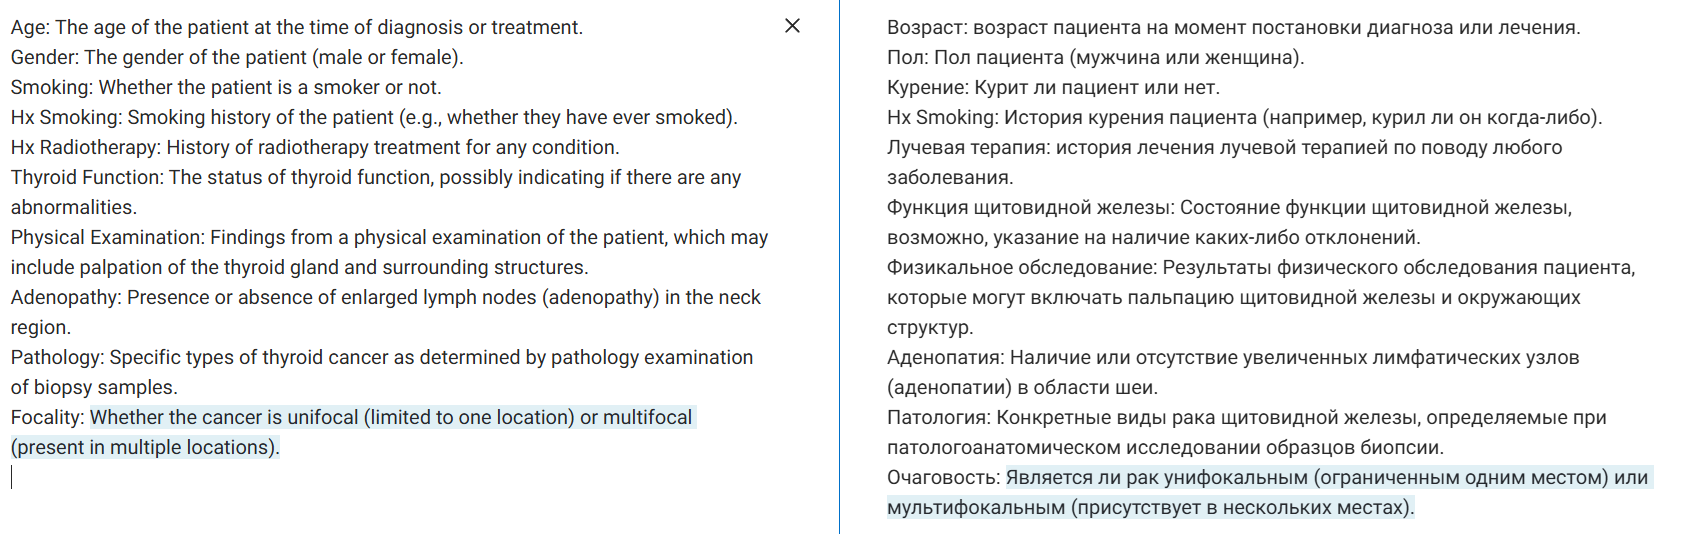

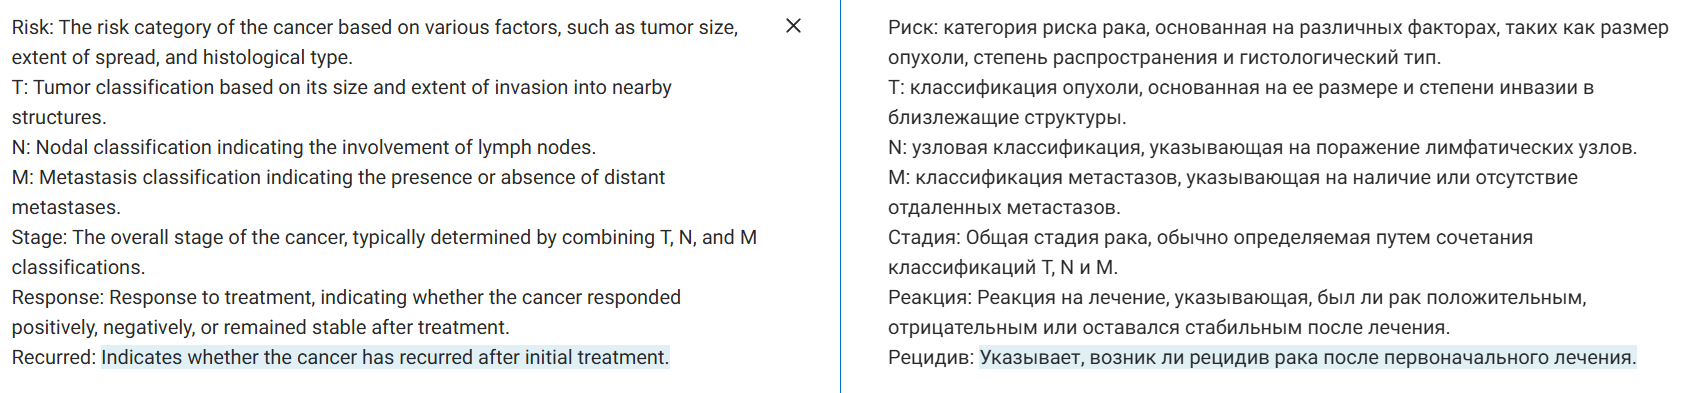

## Data exploration

In [114]:
df.head(5)

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [115]:
print(df.shape)

(383, 17)


## Ести ли пропуски?

In [116]:
df.isnull().values.any() #есть ли пропуски?

False

Пропусков нет, так что удалять ничего не нужно. Теперь заменим категориальные данные на количественные.

In [117]:
df['Gender'] = pd.factorize(df['Gender'])[0]
df['Smoking'] = pd.factorize(df['Smoking'])[0]
df['Hx Smoking'] = pd.factorize(df['Hx Smoking'])[0]
df['Hx Radiothreapy'] = pd.factorize(df['Hx Radiothreapy'])[0]
df['Thyroid Function'] = pd.factorize(df['Thyroid Function'])[0]
df['Physical Examination'] = pd.factorize(df['Physical Examination'])[0]
df['Adenopathy'] = pd.factorize(df['Adenopathy'])[0]
df['Pathology'] = pd.factorize(df['Pathology'])[0]
df['Focality'] = pd.factorize(df['Focality'])[0]
df['Risk'] = pd.factorize(df['Risk'])[0]
df['T'] = pd.factorize(df['T'])[0]
df['N'] = pd.factorize(df['N'])[0]
df['M'] = pd.factorize(df['M'])[0]
df['Stage'] = pd.factorize(df['Stage'])[0]
df['Response'] = pd.factorize(df['Response'])[0]
df['Recurred'] = pd.factorize(df['Recurred'])[0]

## Class distribution ( 0 - non fraudulent, 1 - fraudulent)

In [118]:
df['Recurred'].value_counts()

,count
Recurred,
0,275
1,108


In [119]:
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,34,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
2,30,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0
3,62,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0
4,62,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


<ipython-input-124-317cfd490113>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Recurred'], sort = True)


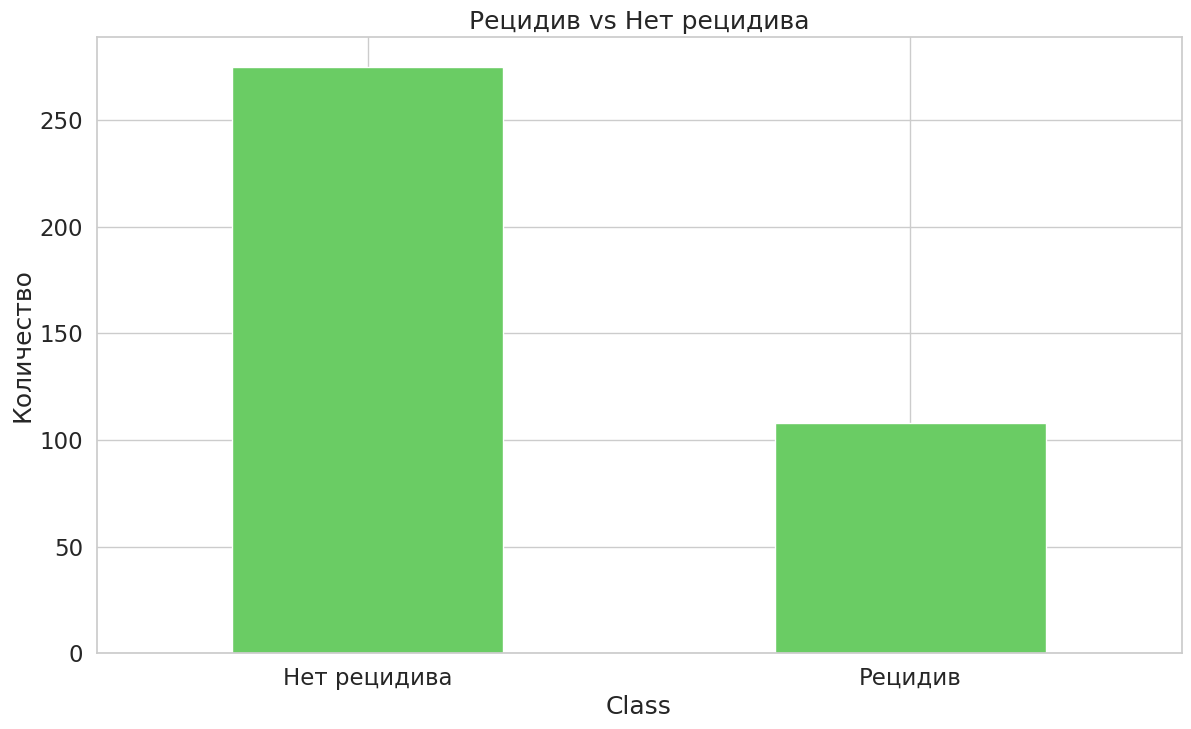

In [124]:
count_classes = pd.value_counts(df['Recurred'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Рецидив vs Нет рецидива")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Количество");

Перевешен в сторону отсуствия рецедива

In [125]:
# Разбиваем датасет по классам: 0 - нет, 1 - рецедив
recurredDF = df[df.Recurred == 1]
normalDF = df[df.Recurred == 0]

In [126]:
recurredDF.shape

(108, 17)

In [127]:
normalDF.shape

(275, 17)

Давайте теперь посмотрим на частоту сердечныз сокращений в двух классах.

In [132]:
recurredDF.Age.describe()

,Age
count,108.000000
mean,47.111111
std,18.267654
min,15.000000
25%,31.750000
50%,44.500000
75%,62.000000
max,82.000000


In [129]:
normalDF.Age.describe()

,Age
count,275.000000
mean,38.414545
std,12.946654
min,17.000000
25%,28.000000
50%,36.000000
75%,46.000000
max,81.000000


Graphically speaking ...`

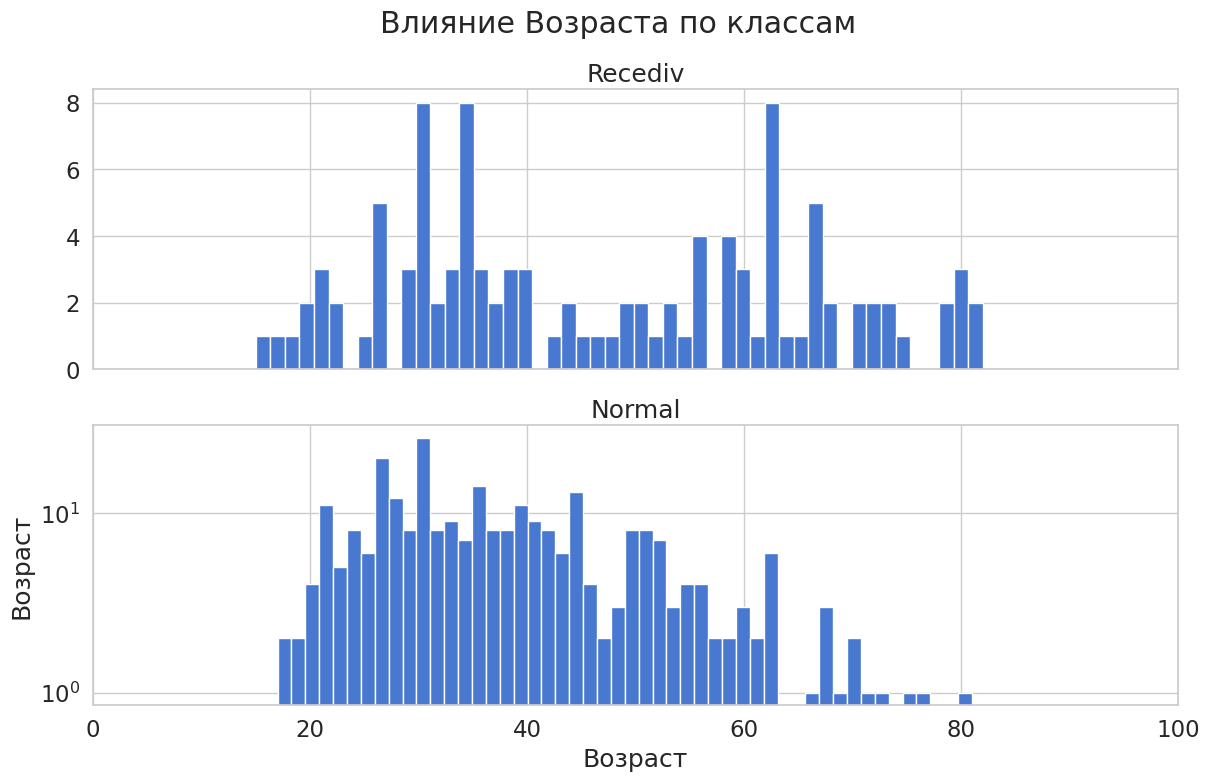

In [133]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Влияние Возраста по классам')

bins = 50

ax1.hist(recurredDF.Age, bins = bins)
ax1.set_title('Recediv')

ax2.hist(normalDF.Age, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Возраст')
plt.ylabel('Возраст')
plt.xlim((0, 100))
plt.yscale('log')
plt.show();

Влияет ли возраст на то, курит человек или нет?

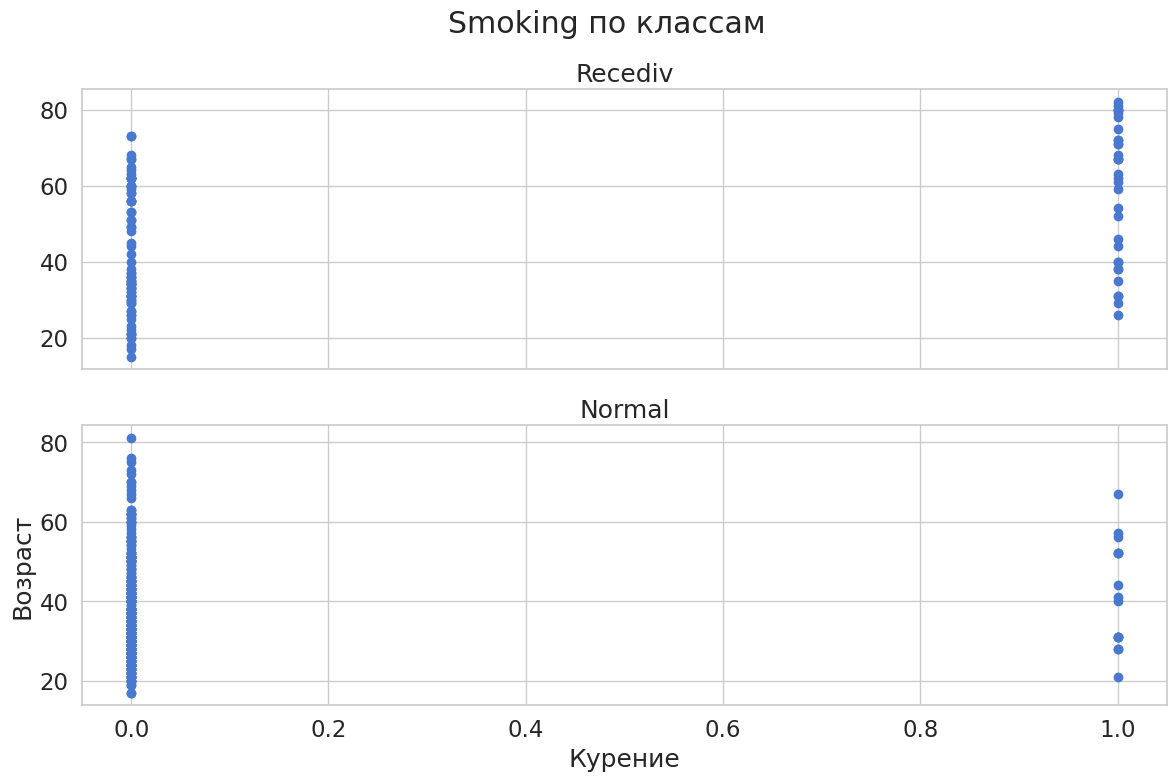

In [71]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Smoking по классам')

ax1.scatter(recurredDF.	Smoking, recurredDF.Age)
ax1.set_title('Recediv')

ax2.scatter(normalDF.	Smoking, normalDF.Age)
ax2.set_title('Normal')

plt.xlabel('Курение')
plt.ylabel('Возраст')
plt.show()

Не влияет

## Preprocessing

Стандартизируем данные

In [134]:
df = df.drop(['Age'], axis=1)

In [135]:
cols = df.columns
cols = ['Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response']

In [136]:
scaler = StandardScaler()
df[cols] = scaler.fit_transform(df[cols])
df.head()

,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,-0.477037,-0.383023,-0.280844,-0.136444,-0.337876,-1.382020,-0.512403,-1.654253,-0.742029,-0.674696,-1.6429,-0.609316,-0.22207,-0.332002,-1.550145,0
1,-0.477037,-0.383023,3.560698,-0.136444,-0.337876,-0.253420,-0.512403,-1.654253,-0.742029,-0.674696,-1.6429,-0.609316,-0.22207,-0.332002,-0.256669,0
2,-0.477037,-0.383023,-0.280844,-0.136444,-0.337876,0.875181,-0.512403,-1.654253,-0.742029,-0.674696,-1.6429,-0.609316,-0.22207,-0.332002,-0.256669,0
3,-0.477037,-0.383023,-0.280844,-0.136444,-0.337876,0.875181,-0.512403,-1.654253,-0.742029,-0.674696,-1.6429,-0.609316,-0.22207,-0.332002,-0.256669,0
4,-0.477037,-0.383023,-0.280844,-0.136444,-0.337876,-0.253420,-0.512403,-1.654253,1.347656,-0.674696,-1.6429,-0.609316,-0.22207,-0.332002,-0.256669,0


### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%, в обучающем наборе данных будут только здоровые, а в тестовом наборе данных будут все

In [137]:

# Разделяем на тестовую и обучающую выборки
X_train, X_test = train_test_split(df, test_size=0.2, random_state=12)
X_train = X_train[X_train.Recurred == 0] # Обучать будем на здоровых
X_train = X_train.drop(['Recurred'], axis=1) # Удаляем целевую перменную
y_test = X_test['Recurred'] # Целевая переменная
X_test = X_test.drop(['Recurred'], axis=1) # Удаляем целевую перменную

# Получаем значения
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values
# Размер тестовой выборки
print(y_test.size)
print(X_train.shape)


77
(231, 15)


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 15, 14, 7, 15 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 15 узлов, соответствующих 15 функциям в элементе входных данных.

In [179]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(15, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 15),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [180]:
model = Autoencoder().double()

In [181]:
num_epochs = 1000   # Количество эпох в автоэнкодере. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32 # Размер мини-пакета, который подаётся в алгоритм. Должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценки градиента для всей обучающей выборки
learning_rate = 1e-3 # На сколько сильно обновляются параметры модели (градиент) на каждом шаге. Чем выше значение, тем медленне обучение

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [182]:
# Представляет данные в виде мини-пакетах и управляет загрузкой данных для эффективного обучения модели
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)



In [183]:
# Функция ошибок
criterion = nn.MSELoss()
# Создаётся оптимизатор, который обновляет параметры модели (градиентный спуск)
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=5e-05)

In [184]:

# Словарь со списком ошибок для обучающей выборки
history = {}
history['train_loss'] = []

- Проходит определенное количество эпох.
- На каждой эпохе проходит через весь обучающий набор данных с расчетом потерь.
- Производится обновление параметров модели с использованием методов обратного распространения.
- В конце сохраняются веса обученной модели для дальнейшего использования.

In [185]:

for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        # Вычисление ошибки
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        # Оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h) # Вычисление средней ошибки
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/1000], loss:0.6977
epoch [2/1000], loss:0.6791
epoch [3/1000], loss:0.6793
epoch [4/1000], loss:0.6665
epoch [5/1000], loss:0.6068
epoch [6/1000], loss:0.6133
epoch [7/1000], loss:0.6316
epoch [8/1000], loss:0.6150
epoch [9/1000], loss:0.6113
epoch [10/1000], loss:0.5996
epoch [11/1000], loss:0.6021
epoch [12/1000], loss:0.5933
epoch [13/1000], loss:0.5980
epoch [14/1000], loss:0.5988
epoch [15/1000], loss:0.5799
epoch [16/1000], loss:0.5665
epoch [17/1000], loss:0.5900
epoch [18/1000], loss:0.5823
epoch [19/1000], loss:0.5824
epoch [20/1000], loss:0.5444
epoch [21/1000], loss:0.5610
epoch [22/1000], loss:0.5522
epoch [23/1000], loss:0.5439
epoch [24/1000], loss:0.5572
epoch [25/1000], loss:0.5386
epoch [26/1000], loss:0.5300
epoch [27/1000], loss:0.5481
epoch [28/1000], loss:0.5815
epoch [29/1000], loss:0.5217
epoch [30/1000], loss:0.5580
epoch [31/1000], loss:0.5774
epoch [32/1000], loss:0.5454
epoch [33/1000], loss:0.5386
epoch [34/1000], loss:0.5072
epoch [35/1000], loss:0

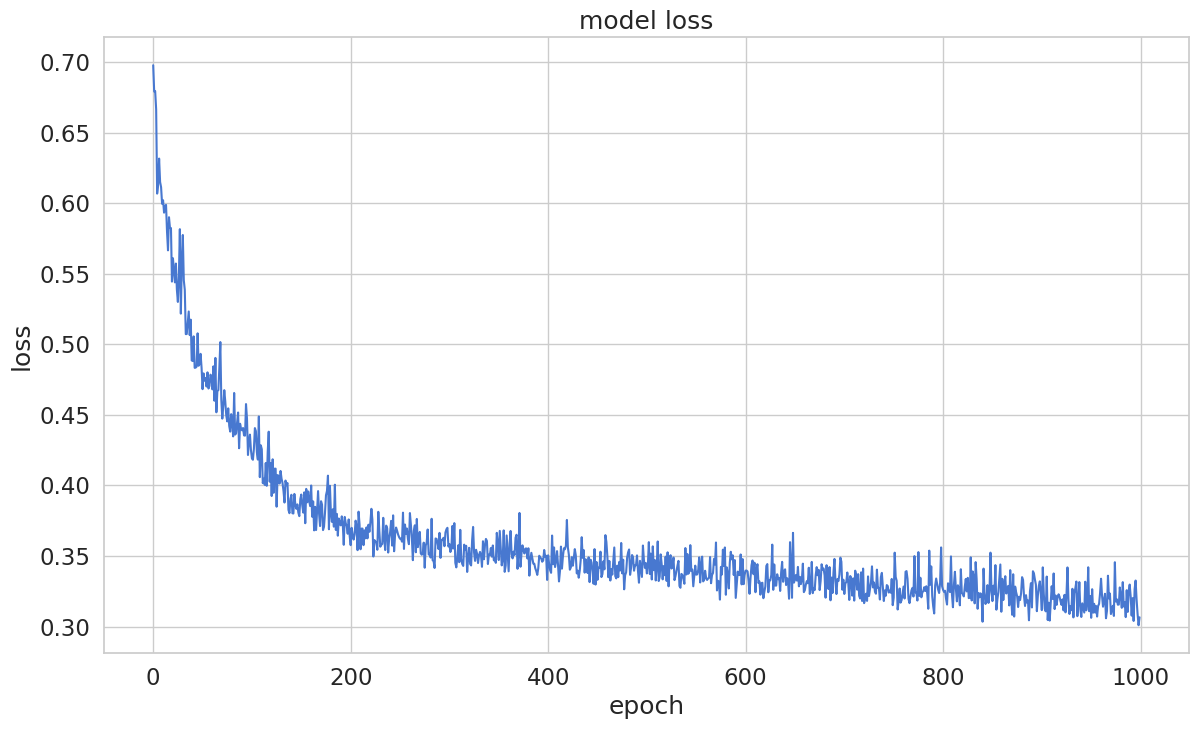

In [186]:
#насколько быстро уменьшается ошибка
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.axis([0,100,0.69,0.80])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Оценка модели

In [187]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        # Подаём в модель тестовые данные
        inputs = data
        outputs = model(inputs)
        # Вычисляем ошибку
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
# Создаём датасет из результатов ошибок и значений целевой переменной
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['recediv'] = y_test

In [188]:
reconstructionErrorDF.describe()

,pred_loss,recediv
count,77.000000,77.000000
mean,1.187124,0.428571
std,1.524866,0.498117
min,0.082873,0.000000
25%,0.275055,0.000000
50%,0.487082,0.000000
75%,1.099646,1.000000
max,7.813177,1.000000


# Ошибки для случаев отсутствия рецедива

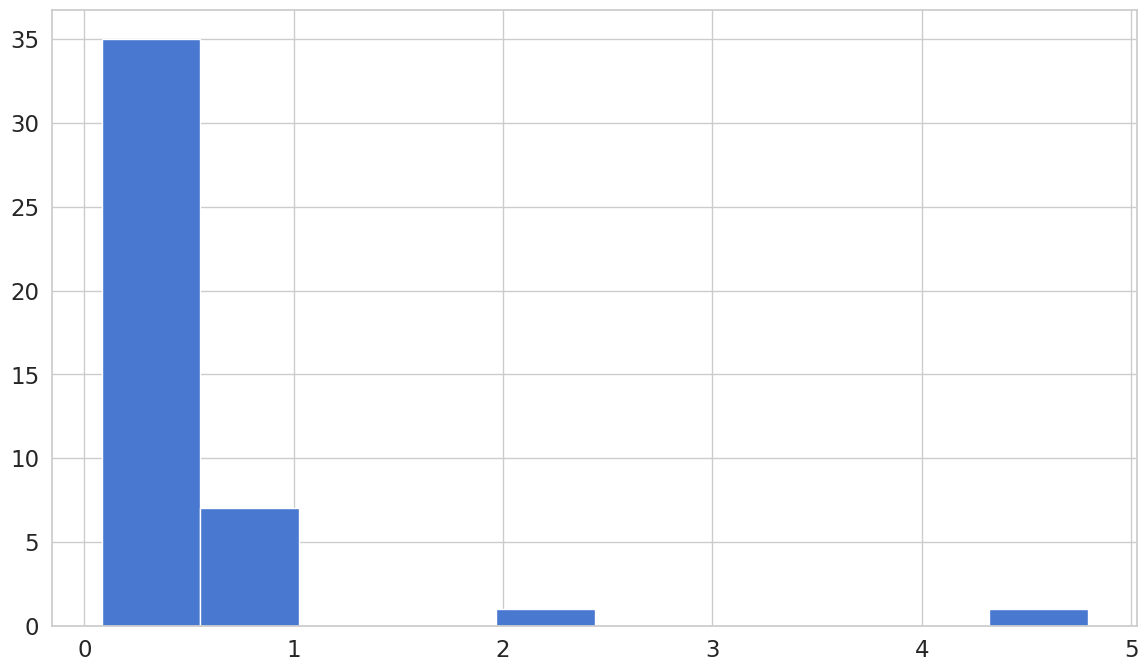

In [189]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['recediv']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Ошибки для рецедива

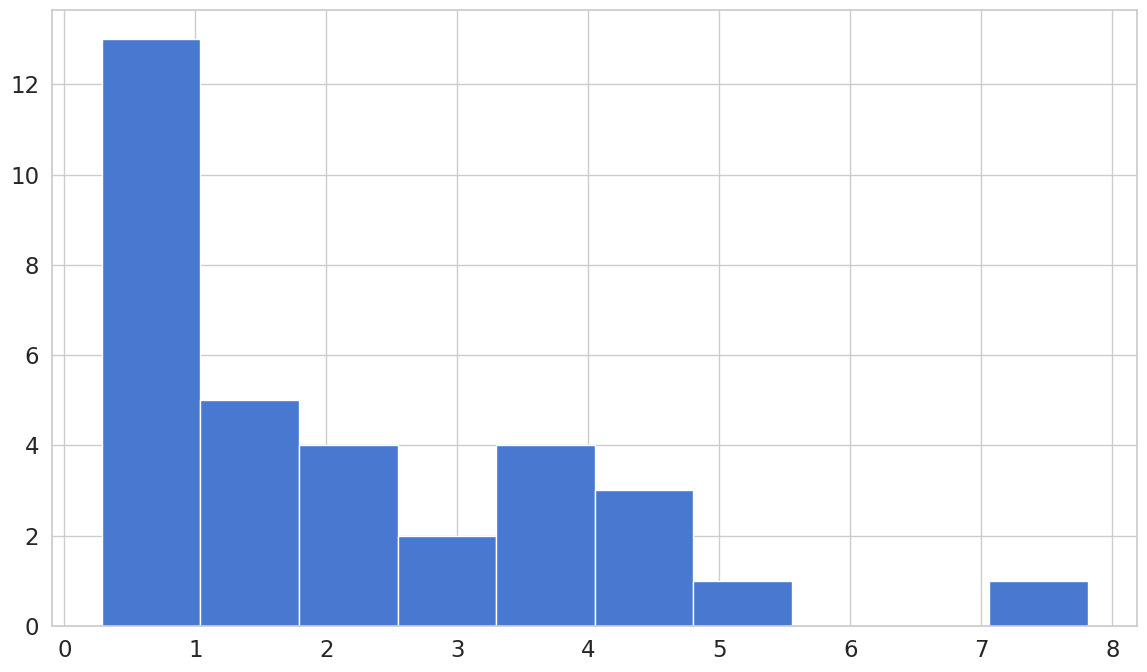

In [190]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['recediv']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

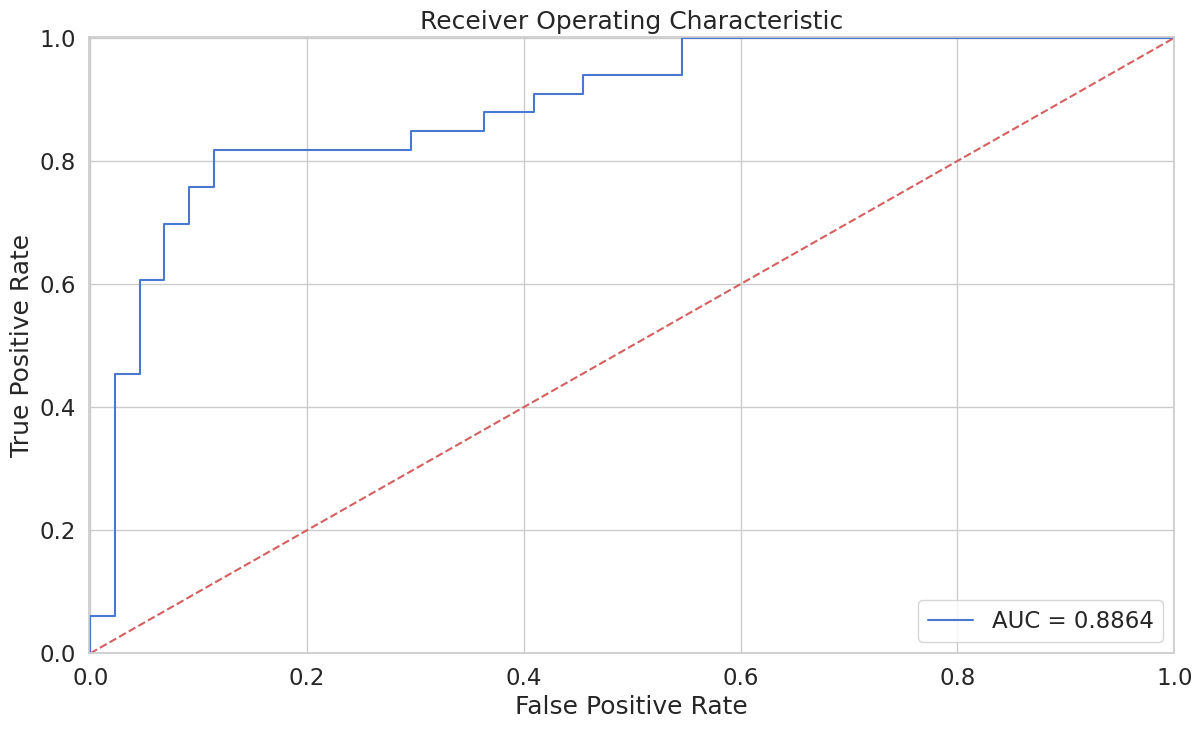

In [192]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.recediv, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

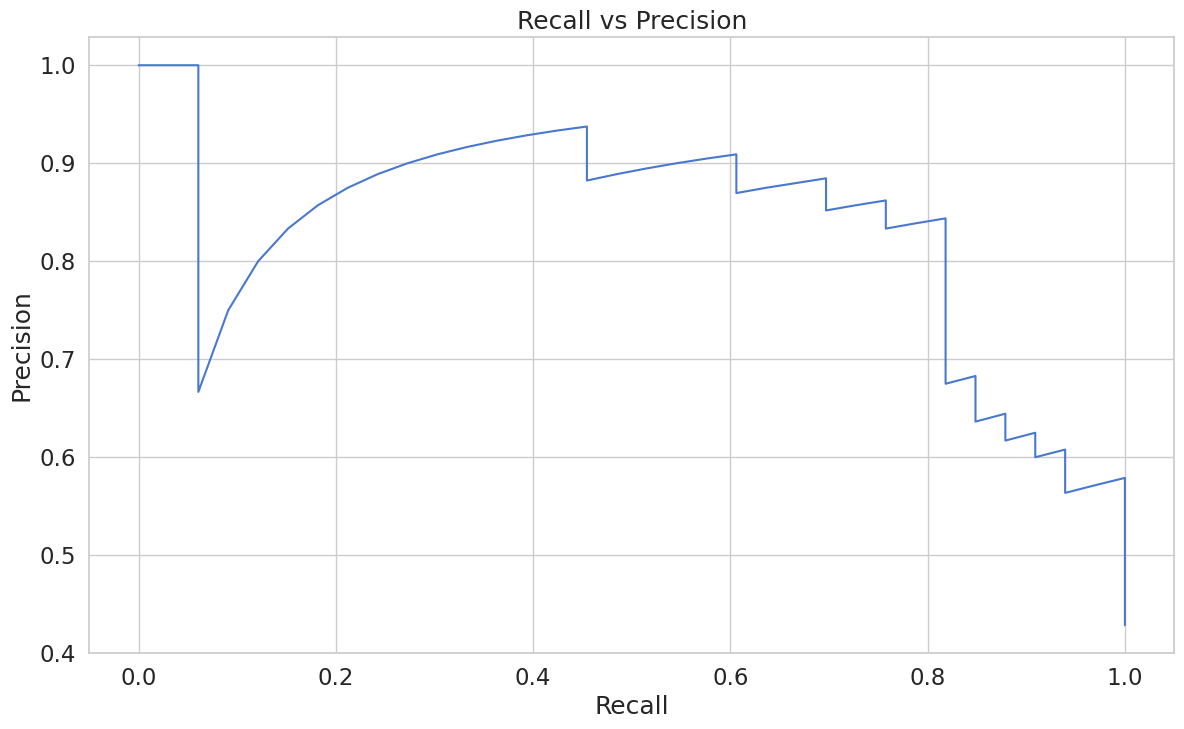

In [193]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.recediv, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

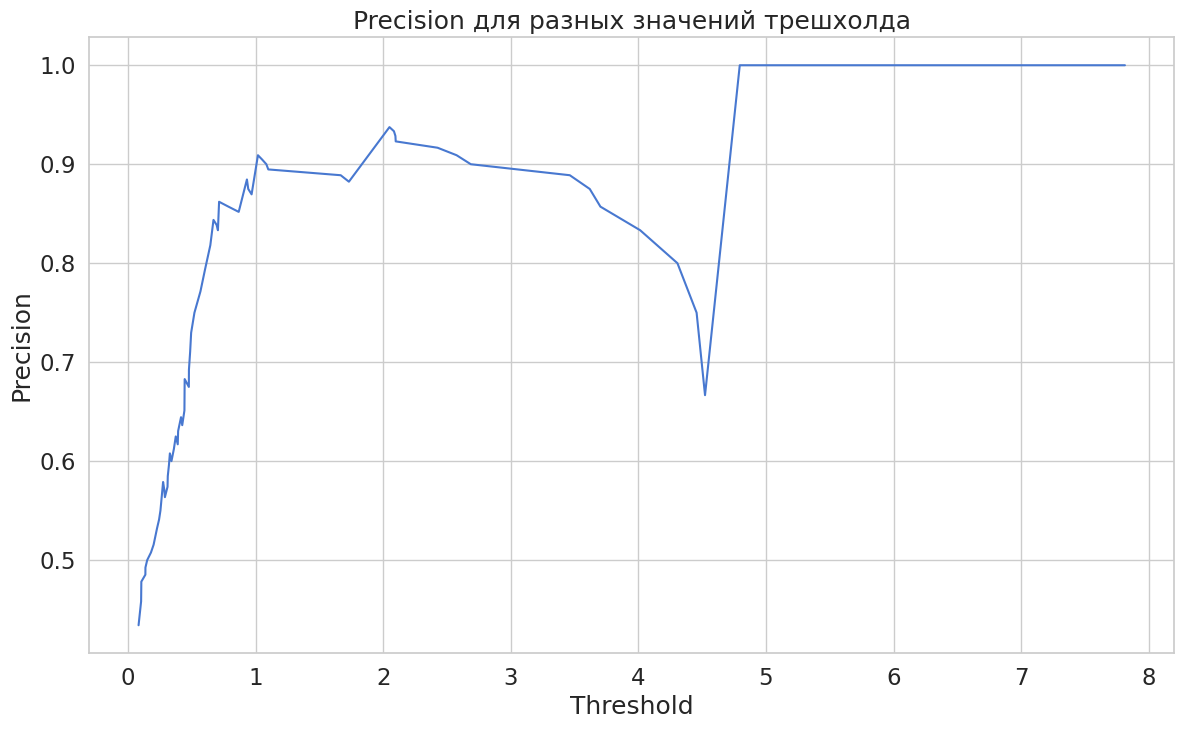

In [198]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


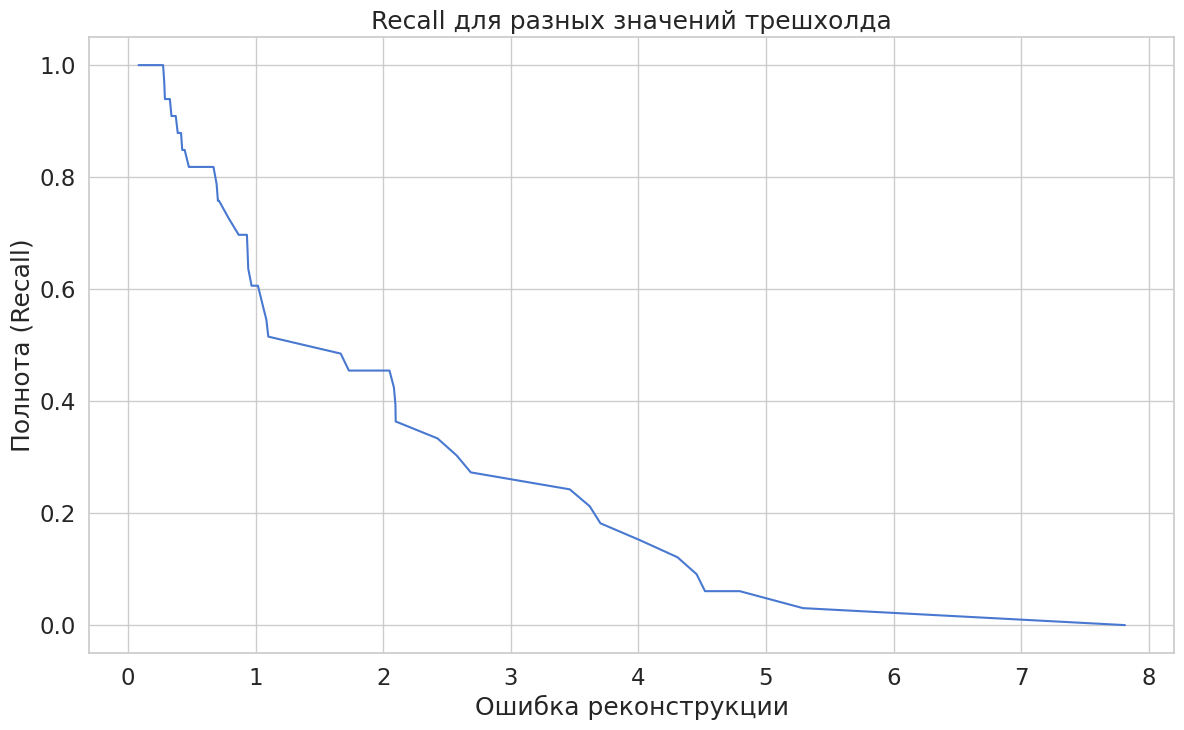

In [199]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

Трешхолд нужно подобрать такой, чтобы была максимальная полнота и урвоень предсказания (больше 0,8). Но чем выше уровень ошибки, тем выше уровень точности, но при этом меньше полнота. Ищем баланс. Примерно 0,8

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, является ли новая/невидимая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как мошенничество (поскольку наша модель должна иметь низкую ошибку при обычных транзакциях). Давайте выберем это значение:

In [202]:
threshold = 0.8

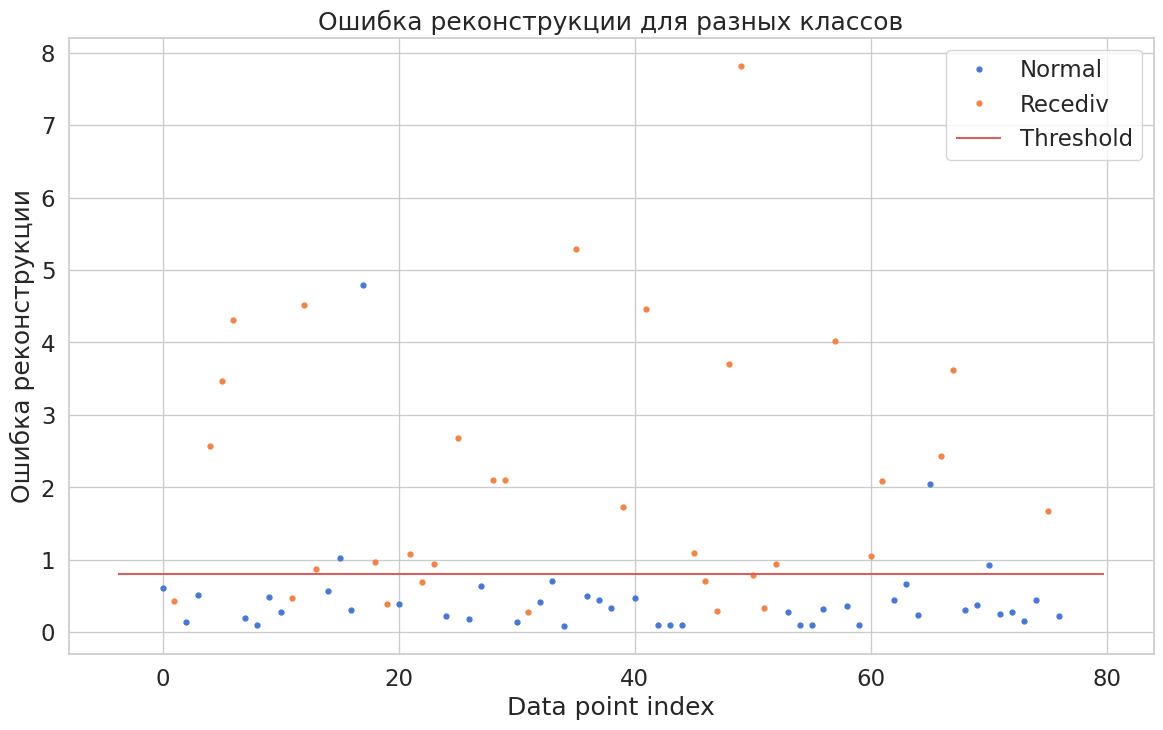

In [203]:
groups = reconstructionErrorDF.groupby('recediv')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Recediv" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-204-337155133819>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


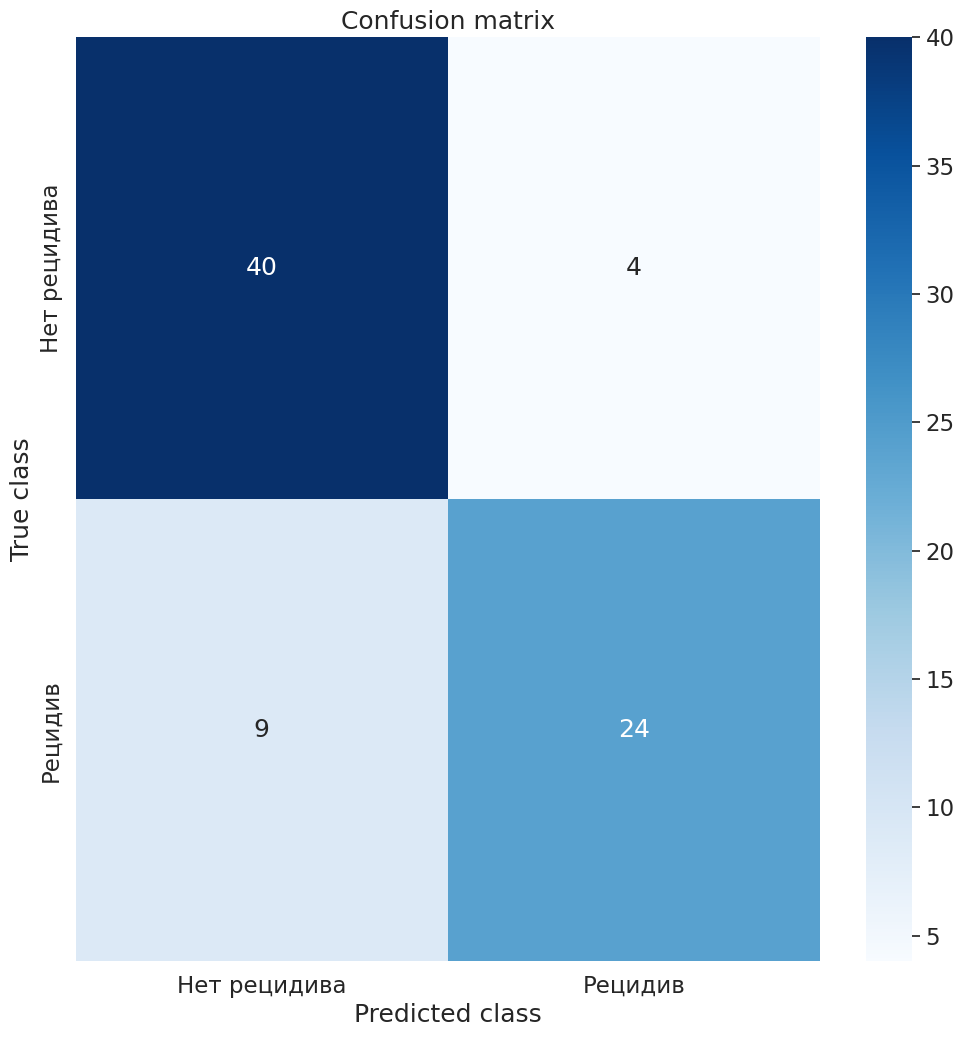

In [204]:

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.recediv, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Выводы


В целом наша модель неплохо научилась отделять по признакам будет человек здоровый или у него повторный рецедив, хотя присутствует некоторые ошибки

In [205]:
true_positives = conf_matrix[1, 1]
true_negatives = conf_matrix[0, 0]
false_positives = conf_matrix[0, 1]
false_negatives = conf_matrix[1, 0]

accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8312
